### Import all libraries needed for the task

In [200]:
import spacy
from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from string import punctuation
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


In [11]:
#!python -m spacy download en_core_web_lg

### Define a function to load data from text file

In [201]:
def load_data(file):
  with open(file, encoding="utf8") as f:
    data = f.read()

  return data

### use the load_data function to read the content of 'sentences.txt'

In [202]:
file="/content/sentences.txt"
data=load_data(file)

### replace SNEU with Scotland North East University in the data

In [203]:
data=data.replace("(SNEU)","").replace("SNEU","Scotland North East University")

### preview the imported data/text

In [204]:
data

'Callum is a lecturer working at Scotland North East University . His research focus is primarily in the field of machine learning. As a result, Callum has published papers describing new techniques applied to Convolutional Neural Networks (CNNs), including “Convolutions and Where to Find Them” and “MinPooling: An Alternative to MaxPooling”. He is most proud of “Counting Cells: A CNN Case study”, which won a Best Paper award at an international conference. This paper described Callum’s collaboration with a research group in digital health on the project “CellCount”, which he has continued to work on since then. \nKen is a research assistant in the Sentiment Analysis Research Group (RG) in Scotland North East University. He was contracted for a large EU project called “Analytics of Reddit posts”. However, that was two years ago and he has recently been made a permanent member of staff. As a research assistant, Ken has had the opportunity to collaborate with many research groups, includi

### Define a function which will be used to apply custom rules to the 'en_core_web_lg' and use it for the NER

In [205]:
def generate_rules(patterns):
  nlp = spacy.load("en_core_web_lg")
  ruler=nlp.add_pipe('entity_ruler', before='ner')
  ruler.add_patterns(patterns) 
  nlp.to_disk("custom_model")


### Define Rules for the custom model

In [206]:
patterns = [    {"label": "DEPT", "pattern": "the Sentiment Analysis Research Group, RG"},
                {"label": "ORG", "pattern": "SNEU"},
                {"label": "ORG", "pattern": "Scotland North East University"},
            {"label": "ORG", "pattern": "Scotland North East University (SNEU)"}]

### Apply the generate_rules function to the patterns specified

In [207]:
generate_rules(patterns)

### load the custom model

In [208]:
nlp =spacy.load("custom_model")

### Fit the imported text data into the loaded model

In [209]:
doc = nlp(data)

### Use displacy from spacy to preview the entities identified

In [210]:
displacy.render(doc, style="ent", jupyter=True)


### Define a function to extract the relationships between entities. This function works be first looking for the ROOT dependency. If the sentence has a ROOT dependency, it will go on to check if the ROOT is followed by an dobj. it will check till all the conditions in the specified rule are met. But if the matcher does not find the root dependency, it will go on to check whether the next item in the rule is available until all the conditions are checked

In [211]:
def extract_relation(doc):

  # Matcher object 
  matcher = Matcher(nlp.vocab)

  #define the rule for the matcher 
  pattern = [ 
            {'DEP':'ROOT'}, 
            {'DEP':'dobj','OP':"?"},
            {'DEP':'det','OP':"?"},
            {'DEP':'compound','OP':"?"},
            {'DEP':'attr','OP':"?"},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

#add the defined rule to the matcher
  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  relation = doc[matches[k][1]:matches[k][2]] 

  return(relation.text)

### Define a function to extract all entities

In [212]:
def generate_entities_relation(sentences):
  ent_=[]
  relation_=[]
  for sentence in sentences:
    docw = nlp(str(sentence))
    ent=[]
    #relation=[]
    allow=False
    allowp=False
    for val in docw.ents:
        ent.append(val.text)
        if val.label_=='PERSON':
          allowp=True
    relation=extract_relation(docw)
    if relation:
      allow=True

    if allow and allowp:
      relation_.append(relation)
      ent_.append(ent)
      print(ent,relation)

    allow=False


  return ent_,relation_

### Make a list of all the sentences in doc

In [213]:
sentences = list(doc.sents)

### use the generate entites function to extract all entities and relations from sentences

In [214]:
ent_,relation_=generate_entities_relation(sentences)

['Callum', 'Scotland North East University'] is a lecturer
['Callum', 'Convolutional Neural Networks', 'Convolutions and Where to Find Them', 'MinPooling: An Alternative to MaxPooling'] published papers
['Callum', 'CellCount'] described
['Ken', 'the Sentiment Analysis Research Group', 'RG', 'Scotland North East University'] is a research assistant in
['Ken', 'the Machine Learning RG', 'Digital Health RG'] had the
['Ken', 'MinPooling: An Alternative to MaxPooling', 'Callum'] published a single
['Jodie', 'Ken', 'PhD'] believes
['Jodie', 'the Machine Learning RG', 'Scotland North East University'] is the professor
['Callum', 'Convolutions and Where to Find Them', 'MinPooling: An Alternative to MaxPooling'] is a mentor to
['Jodie', 'RegTech'] drafting a funding


In [215]:
len(relation_),len(ent_)

(10, 10)

### Define a function to convert the extracted entities and relationships into a dataframe

In [216]:
def convert_to_df(ent_,relation_):
  my_dict = {"source":[],"target":[],"edge":[]};
  for n in range(len(ent_)):
    source=ent_[n][0]
    relation=relation_[n]
    for m in range(1,len(ent_[n])):
      target=ent_[n][m]
      my_dict['source'].append(source)
      my_dict['target'].append(target)
      my_dict['edge'].append(relation)
  df = pd.DataFrame(my_dict)
  return df





### Used the convert_to_df function to convert all entities and relationships into a dataframe "knowledge_graph_df"

In [217]:
knowledge_graph_df=convert_to_df(ent_,relation_)

### Preview the Content in the created df

In [218]:
knowledge_graph_df

,source,target,edge
0,Callum,Scotland North East University,is a lecturer
1,Callum,Convolutional Neural Networks,published papers
2,Callum,Convolutions and Where to Find Them,published papers
3,Callum,MinPooling: An Alternative to MaxPooling,published papers
4,Callum,CellCount,described
5,Ken,the Sentiment Analysis Research Group,is a research assistant in
6,Ken,RG,is a research assistant in
7,Ken,Scotland North East University,is a research assistant in
8,Ken,the Machine Learning RG,had the
9,Ken,Digital Health RG,had the


### Check the statistical summary of the generated dataframe

In [197]:
knowledge_graph_df.describe()

,source,target,edge
count,19,19,19
unique,3,13,10
top,Callum,Scotland North East University,published papers
freq,7,3,3


### set the parameter for generating the knowledge graph

In [198]:
knowledge_graph=nx.from_pandas_edgelist(knowledge_graph_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

### Plot or Visualise the knowledge graph

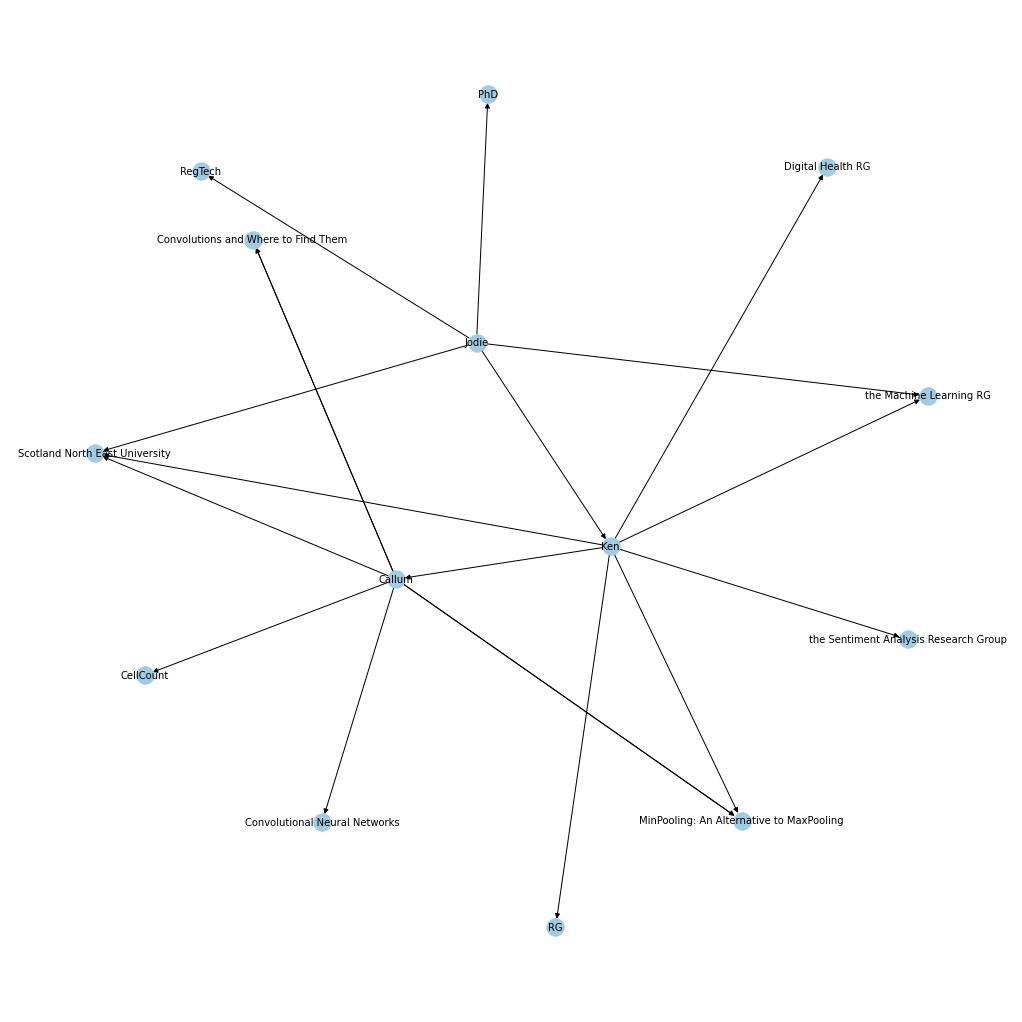

In [223]:
from networkx.algorithms.connectivity.edge_augmentation import weighted_bridge_augmentation
plt.figure(figsize=(14,14))

pos = nx.spring_layout(knowledge_graph,seed=63)
nx.draw(knowledge_graph, with_labels=True, node_color='#A0CBE2', edge_cmap=plt.cm.Blues, pos = pos,font_size=10,font_family="sans-serif")
plt.show()